# Transport patterns between curves
The goal of this notebook is to visualize transport patterns between
curves; it appears that the linear program may be the bottleneck of
the implementation, so we're going to see if we can write a more efficient
implementation here.

First, we'll define some curves.

In [1]:
# imports
import numpy as np
import numpy.linalg as la
import scipy.optimize as op
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

%load_ext line_profiler
%matplotlib inline

## Define (and plot) the line segments

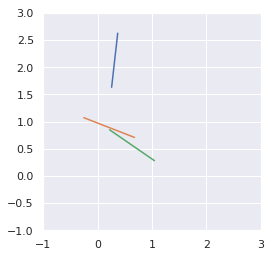

In [2]:
def line_segment(start, vec, seglen, n_pts):
    p0 = np.array(start)
    v = np.array(vec)
    v = v / la.norm(v) * seglen / n_pts
    return np.array([p0+k*v for k in range(n_pts+1)])

def random_uniform_direction():
    theta = np.random.uniform(0, 2*np.pi)
    return [np.cos(theta), np.sin(theta)]

N_DIV = 30
N_CURVE = 3
RMAX = 2.

RND = True

if RND:
    curves = [
        line_segment(np.random.uniform(0, RMAX, size=2), 
                     random_uniform_direction(), 1, N_DIV-1),
        line_segment(np.random.uniform(0, RMAX, size=2), 
                     random_uniform_direction(), 1, N_DIV-1),
        line_segment(np.random.uniform(0, RMAX, size=2), 
                     random_uniform_direction(), 1, N_DIV-1)
    ]
else:
    curves = [
        line_segment((0,1), 
                     (0.001,1), 1, N_DIV-1),
        line_segment((1,0), 
                     (1,0), 1, N_DIV-1),
        line_segment((2,3), 
                     (1,-1), 1, N_DIV-1)
    ]

fig = plt.figure()
ax = fig.add_subplot(111)
for curve in curves:
    sns.lineplot(*curve.T, axes=ax, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
plt.xlim(-1,RMAX+1)
plt.ylim(-1,RMAX+1)
ax.set_aspect(1)
plt.show()

## Geometric median function

In [3]:
# Geometric median
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import numpy.linalg as la

def geometric_median(X, eps=1e-5, max_iter=1000):
    y = np.mean(X, 0)

    for _ in range(max_iter):
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1
    return y

th60 = np.radians(60)
c60, s60 = np.cos(th60), np.sin(th60)
rot60 = np.array([[c60,-s60],[s60,c60]])
rotN60 = np.array([[c60,s60],[-s60,c60]])

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def get_intersect_many(s):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    #s = np.vstack([a1,a2,b1,b2])        # s for stacked
    #print(s.shape)
    h = np.concatenate((s, np.ones((s.shape[0], 4, 1))), axis=2) # h for homogeneous
    #print(h.shape)
    
    l1 = np.cross(h[:,0], h[:,1])           # get first line
    l2 = np.cross(h[:,2], h[:,3])           # get second line
    x, y, z = np.cross(l1, l2).T          # point of intersection
#    if z == 0:                          # lines are parallel
#        return (float('inf'), float('inf'))
    
    return np.array((x/z, y/z))

def geometric_median_3(X, **kwargs):
    """Use geometry to compute fast explicit GM of 3 points"""
    A,B,C = X
    
    ABvec = B-A
    ACvec = C-A
    if (np.arctan2(ACvec[1], ACvec[0]) - np.arctan2(ABvec[1], ABvec[0])) > 0:
        B,C = C,B
        ABvec = B-A
        ACvec = C-A
    
    ARvec = rot60 @ ABvec
    R = X[0]+ARvec
    
    AQvec = rotN60 @ ACvec
    Q = X[0]+AQvec
    
    P = get_intersect(R,X[2],Q,X[1])
    
    S = [A,B,C,P]
    d = [sum(la.norm(z-fp) for z in X) for fp in S]
    
    return S[np.argmin(d)]
    

## Set up the linear program

In [4]:
#%%timeit

N = len(curves[0])

ABmtx = np.zeros([N,N,2])
import itertools

for (ai, a), (bi, b) in itertools.product(enumerate(curves[0]), enumerate(curves[1])):
    ABmtx[ai,bi,:] = b-a
    
ARmtx = np.tensordot(ABmtx, rot60, (2,1))

ACmtx = np.zeros([N,N,2])

for (ai, a), (ci, c) in itertools.product(enumerate(curves[0]), enumerate(curves[2])):
    ACmtx[ai,ci,:] = c-a
    
AQmtx = np.tensordot(ACmtx, rotN60, (2,1))

Betamtx = np.arctan2(ACmtx[:,:,1],ACmtx[:,:,0])
Gammamtx = np.arctan2(ABmtx[:,:,1],ABmtx[:,:,0])

In [5]:
#%%timeit

import math, itertools

def f():
# Specific 3-group case
    groups = {'index': [], 'median': [], 'energy': []}
    
    for i0, A in enumerate(curves[0]):
        K = len(curves[0])
        
        # matrix of angles
        phimtx = Betamtx[i0,:] - Gammamtx[i0,:,np.newaxis]
        pmamtx = (1.*(phimtx < 0))[:,:,np.newaxis]
        
        AR = np.broadcast_to(ARmtx[i0,:,np.newaxis], (K,K,2))
        AQ = np.broadcast_to(AQmtx[i0,np.newaxis], (K,K,2))
        
        AA = np.broadcast_to(A, (K,K,2))
        BB = np.broadcast_to(curves[1][:,np.newaxis], (K,K,2))
        CC = np.broadcast_to(curves[2][np.newaxis], (K,K,2))
        
        RR = (AA+AR)*pmamtx + (BB-AR)*(1-pmamtx)
        QQ = (AA+AQ)*pmamtx + (CC-AQ)*(1-pmamtx)

        index = itertools.product([i0], range(K), range(K))
                
        Batch = np.stack([RR,CC,QQ,BB], axis=2)
        batch = np.reshape(Batch, (K*K,4,2))
        
        Pvec = get_intersect_many(batch).T
            
        Sb = np.zeros((batch.shape[0], 4, 2))
        Sb[:,0] = A
        Sb[:,1] = batch[:,3]
        Sb[:,2] = batch[:,1]
        Sb[:,3] = Pvec

        Zb = Sb[:,0:3,:]

        Evec = np.sum(
            la.norm(Sb[:,:,np.newaxis]-Zb[:,np.newaxis], axis=-1),
            axis=2
        )

        minvec = np.argmin(Evec, axis=1)
        
        Energy = np.take_along_axis(Evec, minvec[:,np.newaxis], 1).flatten()
        Median = np.take_along_axis(Sb, minvec[:,np.newaxis,np.newaxis], 1).reshape(K*K,2)
        
        groups['index'].extend(index)
        groups['median'].extend(Median)
        groups['energy'].extend(Energy)



    return groups


In [6]:
zz = np.random.normal(size=(10,3,2))
rr = np.random.randint(0,3,size=(10,1,1))
np.take_along_axis(zz,rr,1).reshape(10,2)

array([[ 1.0036026 ,  0.55201309],
       [-0.51381566,  1.62433673],
       [ 0.72768571,  0.70930062],
       [ 1.17556061, -0.34497445],
       [-0.72869874, -1.09108112],
       [-0.70445872,  0.4228367 ],
       [-1.10956811,  1.30938841],
       [-0.16663162,  1.49730264],
       [-0.41563154,  0.3429031 ],
       [ 2.46030678,  0.8687452 ]])

In [7]:
groups = f()

Initial implementation runtime was

     11.7 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
After adding a few preprocess steps new time is...

     11.6 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
No on-the-fly arctan gives...

     11.3 s ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
Preprocess rotate gives...

     11.2 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     


In [8]:
medians = np.array(groups['median'])

In [9]:
#pd.DataFrame(groups)

We now move on to setting up (and solving) the linear program proper. Scipy's linprog uses the following form for linear programs. We are solving for \\(x\\) which minimizes
\\[ c^T x \\]
while satisfying the constraints
\\[ A_{ub} x \le b_{ub}, \quad A_{eq} x = b_{eq}, \quad l \le x \le u \\]

In our case, the cost we're minimizing is the linear combination of total median distances

In [10]:
# group energies (c-vector)
energies = np.array(groups['energy'])

In [11]:
def _idxs(index):
    return [i*N_DIV+j for i,j in enumerate(index)]

import scipy.sparse as sparse

def eq_constraints():
    II = np.array(groups['index'])
    II[:,1] += N_DIV
    II[:,2] += 2*N_DIV
    
    # equality constraints
    #A_eq = np.zeros((N_DIV*N_CURVE, len(energies)))
    A_eq = sparse.dok_matrix((N_DIV*N_CURVE, len(energies)))
    
    #print(A_eq.shape, II.shape)
    np.put_along_axis(A_eq, II.T, np.ones((3, len(energies))), 0)
    
    #for i,j in enumerate(II):
    #    A_eq[j, i] = 1.
        
    # transport quantities are all 1 for uniform problem
    b_eq = np.ones(A_eq.shape[0])
    
    return A_eq, b_eq

In [12]:
A_eq, b_eq = eq_constraints()

In [13]:
import numpy as np
solver = 'scipy-interior-point'

def lpsolve(energies, A_eq, b_eq):
    if solver == 'scipy-interior-point':
        from scipy.optimize import linprog
        soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='interior-point')
        return soln
    else:
        from orwrap import Solver

        lp = Solver('TransportPlan', Solver.GLOP_LINEAR_PROGRAMMING)

        var = lp.NumVarDict(range(A_eq.shape[1]), 0, 1, "x")
        
        lp.MakeMatrixConstraint(
            A_eq, 
            var,
            b_eq, b_eq)
        
        obj = lp.Objective()
        for v,e in zip(var.values(), energies):
            obj.SetCoefficient(v, e)
        obj.SetMinimization()
        
        lp.Solve()
        return var
                
    return soln
    
#soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='revised simplex')

In [14]:
%%time

soln=lpsolve(energies, A_eq, b_eq)

/home/harrison/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:68: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  OptimizeWarning)
/home/harrison/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:748: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


CPU times: user 4.59 s, sys: 715 ms, total: 5.3 s
Wall time: 6.01 s


In [15]:
import pandas as pd
solution = pd.DataFrame([
    {'weight': x, 
     'median_x': m[0], 
     'median_y': m[1],
     't_0': j[0],
     't_1': j[1],
     't_2': j[2]} for 
    x,(m,j) in zip(soln['x'], zip(groups['median'], groups['index']))])

print(len(solution[solution['weight'] > 0.001]), "median points")
solution[solution['weight'] > 0.001].sort_values('t_2')

30 median points


,median_x,median_y,t_0,t_1,t_2,weight
2310,0.131200,0.921693,2,17,0,1.0
4141,0.117338,0.940653,4,18,1,1.0
482,0.162765,0.908958,0,16,2,1.0
5073,0.109036,0.961061,5,19,3,1.0
6904,0.097995,0.980084,7,20,4,1.0
1355,0.194892,0.896432,1,15,5,1.0
7836,0.092282,1.000613,8,21,6,1.0
3127,0.227019,0.883905,3,14,7,1.0
8768,0.087493,1.021176,9,22,8,1.0
5799,0.259146,0.871379,6,13,9,1.0


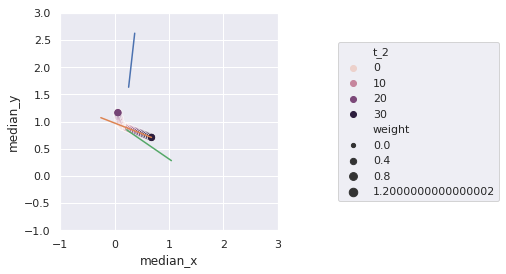

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
for curve in curves:
    sns.lineplot(*curve.T, axes=ax, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution[solution['weight'] > 1e-3], 
                axes=ax, x='median_x', y='median_y',
                hue='t_2', size='weight', size_norm=(0,1))
plt.xlim(-1,RMAX+1)
plt.ylim(-1,RMAX+1)
ax.set_aspect(1)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

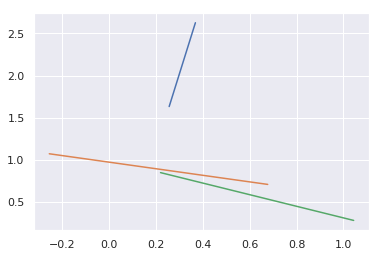

In [17]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
#g = sns.scatterplot(data=solution, 
#                x='median_x', y='median_y',
#                hue='t_2')
#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

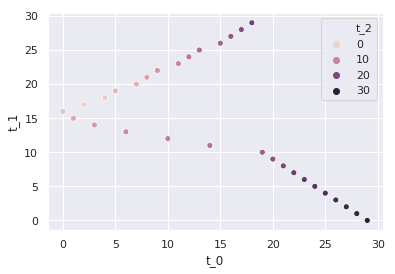

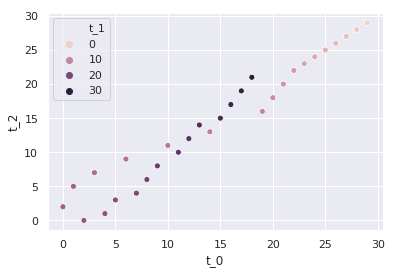

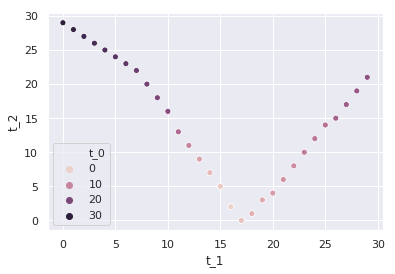

In [18]:
import itertools

sets = ['t_0', 't_1', 't_2']

for x,y,z in [['t_0', 't_1', 't_2'], ['t_0', 't_2', 't_1'], ['t_1', 't_2', 't_0']]:
    sns.scatterplot(data=solution[solution['weight'] > 1e-4], x=x, y=y, hue=z)
    plt.show()

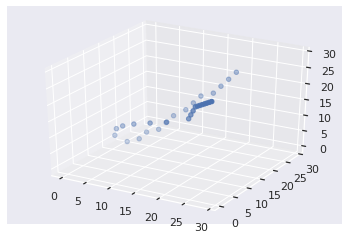

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

psol = solution[solution['weight'] > 1e-3]
ax.scatter(psol['t_0'], psol['t_1'], psol['t_2'])

fig.show()